# Predicting Value of a Jeopardy! Question using Logistic Regression

In [1]:
!pip install portalocker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torchtext
import torchdata
import portalocker
import json

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
filename = 'gdrive/MyDrive/Colab Notebooks/jeopardy_json.json'

with open(filename, 'r', encoding='iso-8859-1') as f:
    data = json.load(f)

In [5]:
values = []
for row in data:
    values.append(row['value'])

print(len(set(values)))

150


In [6]:
def create_value_labels(data):
    values_dict = {}
    idxs = list(range(1, 501))
    for row in data:
        cat = row['value']
        if cat not in values_dict:
            values_dict[cat] = idxs.pop(0)

    return values_dict

values_dict = create_value_labels(data)
len(values_dict)

150

In [7]:
examples_rounds = []
examples_categories = []
examples_adam = []

def create_label_text_pairs(train_data):
    for row in train_data:
        if row['round'] == 'Jeopardy!':
            round_label = 1
        elif row['round'] == 'Double Jeopardy!':
            round_label = 2
        elif row['round'] == 'Final Jeopardy!':
            round_label = 3
        elif row['round'] == 'Tiebreaker':
            round_label = 4
        row_qn = row['question'].replace("'", "")
        examples_rounds.append((round_label, row_qn))
        examples_categories.append((row['category'], row_qn))

        value_label = values_dict[row['value']]
        examples_adam.append((value_label, row_qn))
    return examples_rounds, examples_categories, examples_adam

examples_rounds, examples_categories, examples_values = create_label_text_pairs(data)
examples_values_iter = iter(examples_values)

print(next(examples_values_iter))

(1, 'For the last 8 years of his life, Galileo was under house arrest for espousing this mans theory')


In [8]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(train_iter):
    for _, text in train_iter:
        yield tokenizer(text)

In [9]:
vocab = build_vocab_from_iterator(
    yield_tokens(examples_values_iter), specials=["<unk>"], min_freq=1000)
unk_idx = vocab["<unk>"]
vocab.set_default_index(unk_idx)

In [10]:
from torch.utils.data import DataLoader

def collate_into_bow(batch):
    labels = []
    bow_vectors = []
    for label, text in batch:
        labels.append(label-1)
        bow_vector = [0.0] * len(vocab)
        tokens = tokenizer(text)
        for t in tokens:
            t_idx = vocab[t]
            bow_vector[t_idx] += 1
        bow_vector = [x / len(tokens) for x in bow_vector]
        bow_vectors.append(bow_vector)
    result = (torch.tensor(labels), torch.tensor(bow_vectors))

    return result


def test_collate():
    w1 = vocab.lookup_token(3)
    w2 = vocab.lookup_token(7)
    w3 = vocab.lookup_token(8)
    w4 = vocab.lookup_token(9)
    examples = [
        (1, " ".join([w1, w2, w3, w4])),
        (2, " ".join([w2, w1, w3, w4])),
        (4, " ".join([w4, w2, w3, w4])),
        (3, " ".join([w2, w2, w2, w4])),
        (3, " ".join([w1, w2])),

    ]
    bowt = torch.tensor(
        [
            [0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.25, 0.25, 0.25],
            [0.0, 0.0, 0.0, 0.25, 0.0, 0.0, 0.0, 0.25, 0.25, 0.25],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 0.25, 0.50],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.75, 0.0, 0.25],
            [0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.5, 0.0, 0.00],

        ]) 
    lt, tt = collate_into_bow(examples)
    assert lt.shape == torch.Size([5])
    assert tt.shape == torch.Size([5, len(vocab)])
    print(lt, tt)
    assert torch.equal(lt, torch.tensor([0, 1, 3, 2, 2]))
    assert torch.equal(tt[:,:10], bowt)
    assert tt[:,10:].sum().item() == 0.00
    print('Test passed.')
    
test_collate()

tensor([0, 1, 3, 2, 2]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Test passed.


### BOW Classifier

In [11]:
from torch import nn
import torch.nn.functional as F

class BoWClassifier(nn.Module):
    def __init__(self, num_labels, vocab_size):
        super(BoWClassifier, self).__init__()
        self.linear = nn.Linear(vocab_size, num_labels)
    
    def forward(self, bow_vec):
        return F.log_softmax(self.linear(bow_vec), dim=1)

# Predicting Value

In [12]:
import time

loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader, optimizer):
    model_values.train() # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        model_values.zero_grad()
        log_probs = model_values(text) # forward pass
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')


In [13]:

def get_accuracy(dataloader):
    model_values.eval() # switch to indicate that the model is not in training mode
    with torch.no_grad(): # disables gradient calculation (for when you are sure you will not call Tensor.backward()). This will reduce memory consumption.
        total_examples = 0
        correct = 0
        for labels, text in dataloader: # for each batch in dataloader
            total_examples += text.shape[0]
            probs = model_values(text)
            preds = probs.argmax(1)
            correct += (torch.eq(preds, labels)).sum().item()
        overall_accuracy = correct / total_examples
        return overall_accuracy

In [14]:
from torch.utils.data.dataset import random_split

BATCH_SIZE = 64 # batch size for training

examples_rounds, examples_categories, examples_values = create_label_text_pairs(data)

train_size = int(0.8*len(examples_values))
val_size = int(0.1*len(examples_values))
test_size = int(0.1*len(examples_values))

train_data = examples_values[:train_size]
valid_data = examples_values[train_size:train_size+val_size]
test_data = examples_values[val_size:train_size+val_size+test_size]

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_bow)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_bow)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_into_bow)

In [15]:
num_labels = len(set([label for (label, text) in train_data]))
vocab_size = len(vocab)
model_values = BoWClassifier(num_labels, vocab_size)

At iteration 500 the loss is 2.334.
At iteration 1000 the loss is 2.603.
At iteration 1500 the loss is 2.534.
At iteration 2000 the loss is 2.418.
At iteration 2500 the loss is 2.471.
At iteration 3000 the loss is 2.684.
At iteration 3500 the loss is 2.628.
At iteration 4000 the loss is 2.415.
At iteration 4500 the loss is 2.379.
At iteration 5000 the loss is 2.766.

After epoch 1 the validation accuracy is 0.102.

At iteration 500 the loss is 2.537.
At iteration 1000 the loss is 2.366.
At iteration 1500 the loss is 2.350.
At iteration 2000 the loss is 2.245.
At iteration 2500 the loss is 2.378.
At iteration 3000 the loss is 2.458.
At iteration 3500 the loss is 2.400.
At iteration 4000 the loss is 2.666.
At iteration 4500 the loss is 2.693.
At iteration 5000 the loss is 2.381.

After epoch 2 the validation accuracy is 0.151.

At iteration 500 the loss is 2.686.
At iteration 1000 the loss is 2.372.
At iteration 1500 the loss is 2.569.
At iteration 2000 the loss is 2.598.
At iteration 25

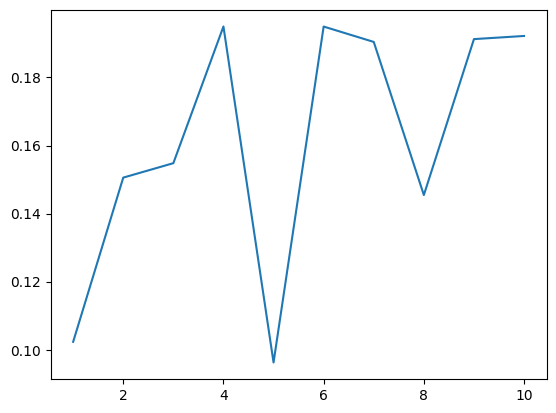

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 10 # epoch
optimizer = torch.optim.SGD(model_values.parameters(), lr=3)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

In [17]:
test_accuracy = get_accuracy(test_dataloader)
print("test accuracy from model trained on 10 epochs using SGD optimizer:", test_accuracy)

test accuracy from model trained on 10 epochs using SGD optimizer: 0.1917694904142145


## Using the Adam Optimizer
Given the better convergence properties of the Adam optimizer, we test a model using it instead of the SGD optimizer.

In [18]:
from torch.utils.data.dataset import random_split

BATCH_SIZE = 64 # batch size for training

examples_rounds, examples_categories, examples_values = create_label_text_pairs(data)

train_size = int(0.8*len(examples_values))
val_size = int(0.1*len(examples_values))
test_size = int(0.1*len(examples_values))

train_data = examples_values[:train_size]
valid_data = examples_values[train_size:train_size+val_size]
test_data = examples_values[val_size:train_size+val_size+test_size]

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_bow)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_bow)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_into_bow)

num_labels = len(set([label for (label, text) in train_data]))
vocab_size = len(vocab)
model_adam = BoWClassifier(num_labels, vocab_size)

In [19]:
import time

loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader, optimizer):
    model_adam.train() # Sets the module in training mode.
    log_interval = 500

    for idx, (label, text) in enumerate(dataloader):
        model_adam.zero_grad()
        log_probs = model_adam(text) # forward pass
        loss = loss_function(log_probs, label)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')


def get_accuracy(dataloader):
    model_adam.eval() # switch to indicate that the model is not in training mode
    with torch.no_grad(): # disables gradient calculation (for when you are sure you will not call Tensor.backward()). This will reduce memory consumption.
        total_examples = 0
        correct = 0
        for labels, text in dataloader: # for each batch in dataloader
            total_examples += text.shape[0]
            probs = model_adam(text)
            preds = probs.argmax(1)
            correct += (torch.eq(preds, labels)).sum().item()
        overall_accuracy = correct / total_examples
        return overall_accuracy

At iteration 500 the loss is 4.604.
At iteration 1000 the loss is 4.960.
At iteration 1500 the loss is 4.236.
At iteration 2000 the loss is 3.595.
At iteration 2500 the loss is 4.784.
At iteration 3000 the loss is 4.077.
At iteration 3500 the loss is 4.594.
At iteration 4000 the loss is 4.436.
At iteration 4500 the loss is 5.258.
At iteration 5000 the loss is 5.533.
At iteration 5500 the loss is 4.548.
At iteration 6000 the loss is 6.042.
At iteration 6500 the loss is 4.286.
At iteration 7000 the loss is 4.005.
At iteration 7500 the loss is 8.371.
At iteration 8000 the loss is 4.950.

After epoch 1 the validation accuracy is 0.137.

At iteration 500 the loss is 4.603.
At iteration 1000 the loss is 3.497.
At iteration 1500 the loss is 5.069.
At iteration 2000 the loss is 3.650.
At iteration 2500 the loss is 3.574.
At iteration 3000 the loss is 4.706.
At iteration 3500 the loss is 3.349.
At iteration 4000 the loss is 4.506.
At iteration 4500 the loss is 4.957.
At iteration 5000 the loss 

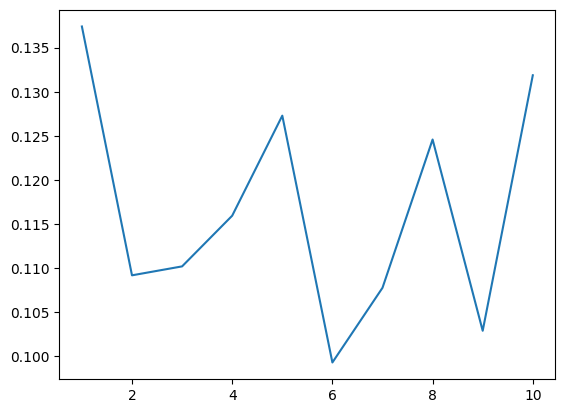

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 10 # epoch
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=3)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer_adam)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

In [21]:
test_accuracy = get_accuracy(test_dataloader)
print("test accuracy from model trained on 10 epochs using Adam optimizer:", test_accuracy)

test accuracy from model trained on 10 epochs using Adam optimizer: 0.131539274488613
